In [1]:
import numpy as np 
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import re
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.colors as mcolors
from sklearn.manifold import TSNE
import nltk

In [2]:
dataset = pd.read_csv("RestoInfo.csv")

In [3]:
dataset.head()

,Unnamed: 0,name,online_order,book_table,rate,votes,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,46019,Unique Brew Cafe Resto,No,No,NaN,0,Indiranagar,Quick Bites,NaN,Fast Food,200,[],[],Dine-out,Old Airport Road
1,28849,Jayanthi Sagar,No,No,3.1 /5,21,Koramangala 5th Block,Quick Bites,NaN,"South Indian, North Indian, Chinese",200,"[('Rated 2.0', ""RATEDn Works only because it'...",[],Dine-out,Koramangala 4th Block
2,19855,Rock Stone Ice Cream Factory,Yes,No,4.0/5,131,BTM,Dessert Parlor,"Icecream Cake, Brownie, Waffles, Chocolate Ice...",Ice Cream,230,"[('Rated 4.0', ""RATEDn Ice creams are really ...","['Midnight Indulgence Cake', 'Butterscotch Mel...",Delivery,Jayanagar
3,35188,Punjabi by Nature 2.0,No,No,4.2 /5,3236,BTM,"Casual Dining, Microbrewery","Paneer Tikki, Mutton Raan, Mango Margarita, Cr...",North Indian,NaN,"[('Rated 3.0', ""RATEDn It has a beautiful amb...",[],Delivery,Koramangala 7th Block
4,7070,Rayalaseema Chefs,Yes,Yes,3.9/5,225,Marathahalli,Casual Dining,"Bamboo Chicken, Butter Naan, Mutton Biryani, P...","North Indian, Biryani, Andhra, Chinese",800,"[('Rated 5.0', 'RATEDn Had Good experience wi...",[],Delivery,Brookefield


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2069 entries, 0 to 2068
Data columns (total 15 columns):
Unnamed: 0                     2069 non-null int64
name                           2069 non-null object
online_order                   2069 non-null object
book_table                     2069 non-null object
rate                           1770 non-null object
votes                          2069 non-null int64
location                       2069 non-null object
rest_type                      2052 non-null object
dish_liked                     962 non-null object
cuisines                       2069 non-null object
approx_cost(for two people)    2053 non-null object
reviews_list                   2069 non-null object
menu_item                      2069 non-null object
listed_in(type)                2069 non-null object
listed_in(city)                2069 non-null object
dtypes: int64(2), object(13)
memory usage: 242.6+ KB


In [5]:
dataset = dataset.rename(columns={"Unnamed: 0":"SNO"})

In [6]:
dataset.shape

(2069, 15)

In [7]:
dataset.head(2)

,SNO,name,online_order,book_table,rate,votes,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,46019,Unique Brew Cafe Resto,No,No,NaN,0,Indiranagar,Quick Bites,NaN,Fast Food,200,[],[],Dine-out,Old Airport Road
1,28849,Jayanthi Sagar,No,No,3.1 /5,21,Koramangala 5th Block,Quick Bites,NaN,"South Indian, North Indian, Chinese",200,"[('Rated 2.0', ""RATEDn Works only because it'...",[],Dine-out,Koramangala 4th Block


In [8]:
# explore columns related to the addrress
dataset.loc[:,['location','listed_in(city)']].sample(8,random_state=1)

,location,listed_in(city)
724,BTM,Koramangala 4th Block
348,Koramangala 7th Block,Koramangala 6th Block
102,Malleshwaram,Malleshwaram
1079,BTM,Jayanagar
1269,Malleshwaram,Rajajinagar
607,Ulsoor,Church Street
749,Indiranagar,Old Airport Road
1081,Jeevan Bhima Nagar,Indiranagar


In [9]:
# Both columns are represesnting same information hence, removing one of them. We are only interested in ADDRESS
dataset.drop(columns=['listed_in(city)'], inplace=True, axis=1)

In [10]:
dataset.columns

Index(['SNO', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'location', 'rest_type', 'dish_liked', 'cuisines',
       'approx_cost(for two people)', 'reviews_list', 'menu_item',
       'listed_in(type)'],
      dtype='object')

In [11]:
# rename non descriptive columns
dataset.rename(columns={'approx_cost(for two people)': 'average_cost', 'listed_in(type)': 'meal_type'}, inplace=True)

In [12]:
# checking and removing for duplicate rows
dataset.duplicated().sum() 
dataset.drop_duplicates(inplace=True)

In [13]:
# check for null values
((dataset.isnull().sum()/dataset.shape[0])*100).round(2)

SNO              0.00
name             0.00
online_order     0.00
book_table       0.00
rate            14.45
votes            0.00
location         0.00
rest_type        0.82
dish_liked      53.50
cuisines         0.00
average_cost     0.77
reviews_list     0.00
menu_item        0.00
meal_type        0.00
dtype: float64

As we notice around 54 % of data will be lost if we delete the nan values in dish_liked column
We will keep that column for now
let's check for rate column as it contains 15% of its points as null value

In [14]:
# Adjust the column names
dataset['name'] = dataset['name'].apply(lambda x:x.title())
dataset['online_order'].replace(('Yes','No'),(True, False),inplace=True)
dataset['book_table'].replace(('Yes','No'),(True, False),inplace=True)

In [15]:
dataset.head()

,SNO,name,online_order,book_table,rate,votes,location,rest_type,dish_liked,cuisines,average_cost,reviews_list,menu_item,meal_type
0,46019,Unique Brew Cafe Resto,False,False,NaN,0,Indiranagar,Quick Bites,NaN,Fast Food,200,[],[],Dine-out
1,28849,Jayanthi Sagar,False,False,3.1 /5,21,Koramangala 5th Block,Quick Bites,NaN,"South Indian, North Indian, Chinese",200,"[('Rated 2.0', ""RATEDn Works only because it'...",[],Dine-out
2,19855,Rock Stone Ice Cream Factory,True,False,4.0/5,131,BTM,Dessert Parlor,"Icecream Cake, Brownie, Waffles, Chocolate Ice...",Ice Cream,230,"[('Rated 4.0', ""RATEDn Ice creams are really ...","['Midnight Indulgence Cake', 'Butterscotch Mel...",Delivery
3,35188,Punjabi By Nature 2.0,False,False,4.2 /5,3236,BTM,"Casual Dining, Microbrewery","Paneer Tikki, Mutton Raan, Mango Margarita, Cr...",North Indian,NaN,"[('Rated 3.0', ""RATEDn It has a beautiful amb...",[],Delivery
4,7070,Rayalaseema Chefs,True,True,3.9/5,225,Marathahalli,Casual Dining,"Bamboo Chicken, Butter Naan, Mutton Biryani, P...","North Indian, Biryani, Andhra, Chinese",800,"[('Rated 5.0', 'RATEDn Had Good experience wi...",[],Delivery


In [16]:
dataset['rate'].unique()

array([nan, '3.1 /5', '4.0/5', '4.2 /5', '3.9/5', '4.1 /5', '3.3/5',
       '4.4/5', '3.8/5', '3.1/5', '3.5/5', '3.8 /5', '2.9/5', '4.1/5',
       '3.7/5', '3.5 /5', '3.4 /5', '3.7 /5', '4.5/5', '4.3 /5', '3.6/5',
       '2.8 /5', '3.2/5', '4.0 /5', '2.9 /5', '3.0 /5', '4.4 /5',
       '3.2 /5', '4.6 /5', 'NEW', '3.9 /5', '3.0/5', '4.8 /5', '3.6 /5',
       '3.3 /5', '4.5 /5', '2.8/5', '3.4/5', '4.2/5', '2.1/5', '4.9 /5',
       '4.3/5', '2.7/5', '2.6/5', '2.7 /5', '2.2/5', '2.4/5', '2.5 /5',
       '2.1 /5', '1.8 /5', '2.6 /5', '4.7 /5', '-', '2.3/5', '4.6/5',
       '2.2 /5'], dtype=object)

So, Now we found this column has 'NEW' ,"-" values which should replaced by np.nan
there is /5 as extra and no need for it
values represents as strings instead of float

In [17]:
# adjust rate column 
# convert "NEW" & "-" to np.nan
dataset['rate'].replace(('NEW','-'),np.nan,inplace =True)
# first make it as string and removing '/5'
dataset['rate'] = dataset['rate'].apply(lambda x: str(x).split('/')[0])

In [18]:
dataset['rate'].dtype

dtype('O')

In [19]:
dataset['rate'].unique()

array(['nan', '3.1 ', '4.0', '4.2 ', '3.9', '4.1 ', '3.3', '4.4', '3.8',
       '3.1', '3.5', '3.8 ', '2.9', '4.1', '3.7', '3.5 ', '3.4 ', '3.7 ',
       '4.5', '4.3 ', '3.6', '2.8 ', '3.2', '4.0 ', '2.9 ', '3.0 ',
       '4.4 ', '3.2 ', '4.6 ', '3.9 ', '3.0', '4.8 ', '3.6 ', '3.3 ',
       '4.5 ', '2.8', '3.4', '4.2', '2.1', '4.9 ', '4.3', '2.7', '2.6',
       '2.7 ', '2.2', '2.4', '2.5 ', '2.1 ', '1.8 ', '2.6 ', '4.7 ',
       '2.3', '4.6', '2.2 '], dtype=object)

In [20]:
dataset.head(2)

,SNO,name,online_order,book_table,rate,votes,location,rest_type,dish_liked,cuisines,average_cost,reviews_list,menu_item,meal_type
0,46019,Unique Brew Cafe Resto,False,False,nan,0,Indiranagar,Quick Bites,NaN,Fast Food,200,[],[],Dine-out
1,28849,Jayanthi Sagar,False,False,3.1,21,Koramangala 5th Block,Quick Bites,NaN,"South Indian, North Indian, Chinese",200,"[('Rated 2.0', ""RATEDn Works only because it'...",[],Dine-out


In [21]:
# Adjusting average_cost
dataset['average_cost'] = dataset['average_cost'].astype('str')
dataset['average_cost'] = dataset['average_cost'].apply(lambda x: x.replace(',',''))
dataset['average_cost'] = dataset['average_cost'].astype("float")

In [22]:
#Encode the input Variables
def Encode(dataset):
    for column in dataset.columns[~dataset.columns.isin(['average_cost', 'votes'])]:
        dataset[column] = dataset[column].factorize()[0]
    return dataset

dataset_en = Encode(dataset.copy())
dataset_en.drop(['SNO'], inplace= True, axis =1)

Index(['SNO', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'location', 'rest_type', 'dish_liked', 'cuisines', 'average_cost',
       'reviews_list', 'menu_item', 'meal_type'],
      dtype='object')

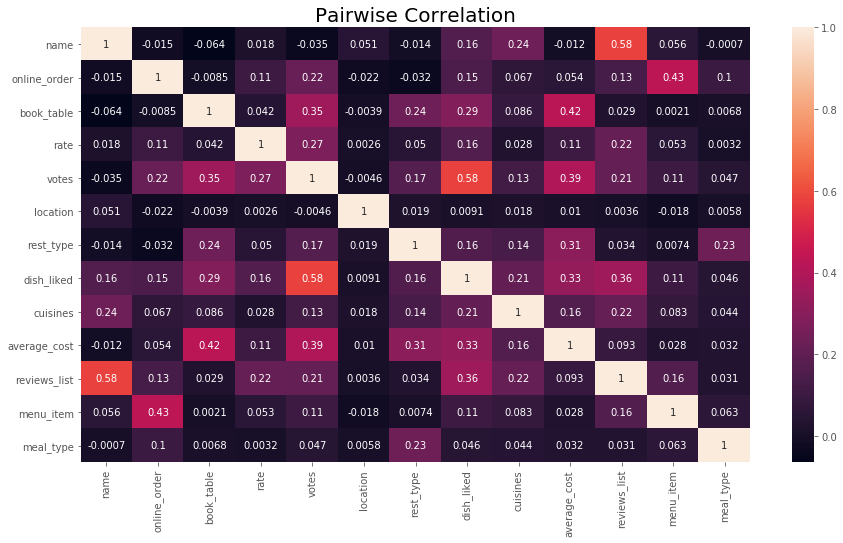

In [23]:
#Get Correlation between different variables
corr = dataset_en.corr(method='kendall')
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True)
plt.title('Pairwise Correlation', fontweight = 30, fontsize = 20)
plt.savefig('code/output/Fig_1-Correlation.png', dpi=300) 
dataset.columns

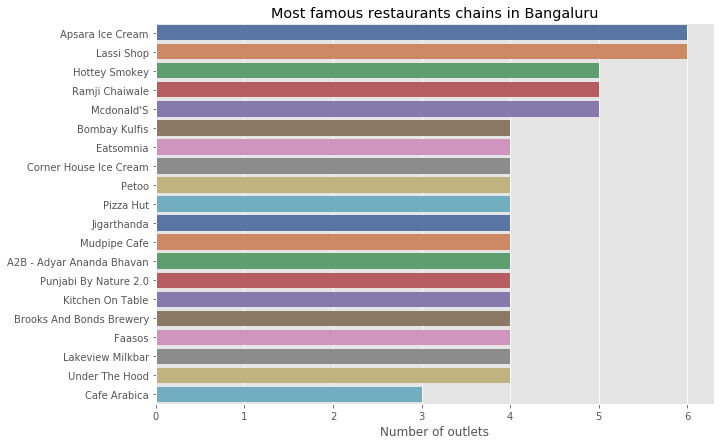

In [24]:
plt.figure(figsize=(10,7))
chains=dataset['name'].value_counts()[:20]
sns.barplot(x=chains,y=chains.index,palette='deep')
plt.title("Most famous restaurants chains in Bangaluru")
plt.xlabel("Number of outlets")
plt.savefig('code/output/Fig_2-Famous_restaurant_chains.png', dpi=300) 

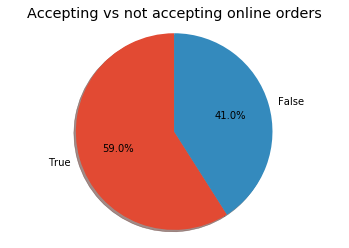

In [25]:
x=dataset['online_order'].value_counts()
sizes = x
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=x.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.title("Accepting vs not accepting online orders")
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('code/output/Fig_3-Online_order_acceptance.png', dpi=300) 
plt.show()
    

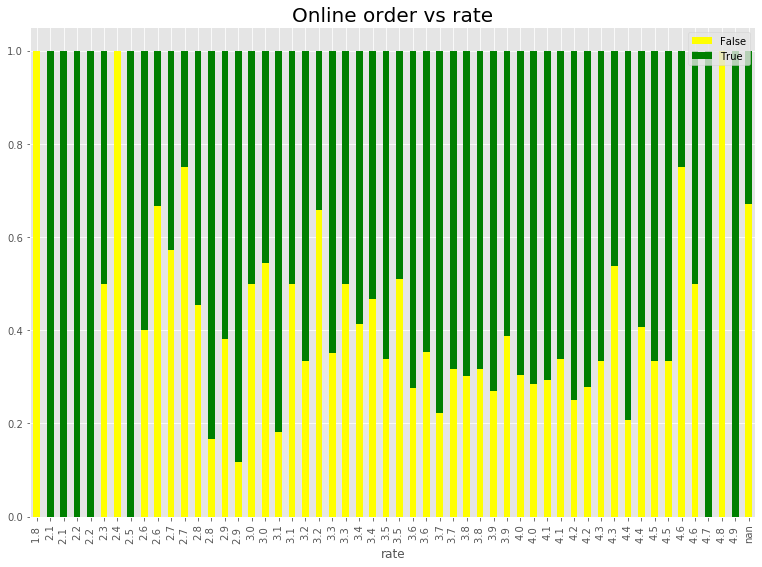

In [26]:
#Table online_order vs Rate
plt.rcParams['figure.figsize'] = (13, 9)
Y = pd.crosstab(dataset['rate'], dataset['online_order'])
Y.div(Y.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True,color=['yellow', 'green'])
plt.title('Online order vs rate', fontweight = 30, fontsize = 20)
plt.legend(loc="upper right")
plt.savefig('code/output/Fig_4-Online_order_vs_rating.png', dpi=300) 
plt.show()

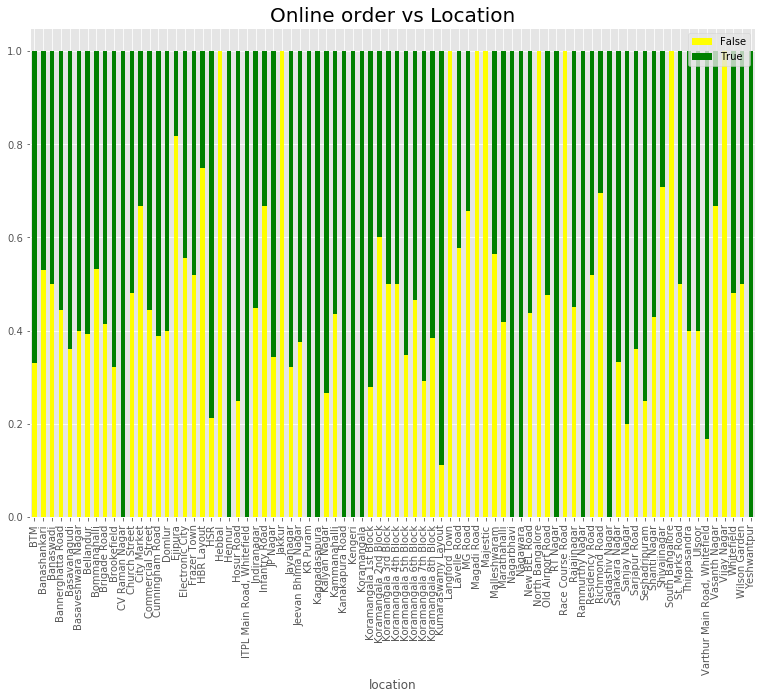

In [27]:
#Table online_order vs Rate
plt.rcParams['figure.figsize'] = (13, 9)
Y = pd.crosstab(dataset['location'], dataset['online_order'])
Y.div(Y.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True,color=['yellow', 'green'])
plt.title('Online order vs Location', fontweight = 30, fontsize = 20)
plt.legend(loc="upper right")
plt.savefig('code/output/Fig_6-Online_order_vs_location.png', dpi=300) 
plt.show()

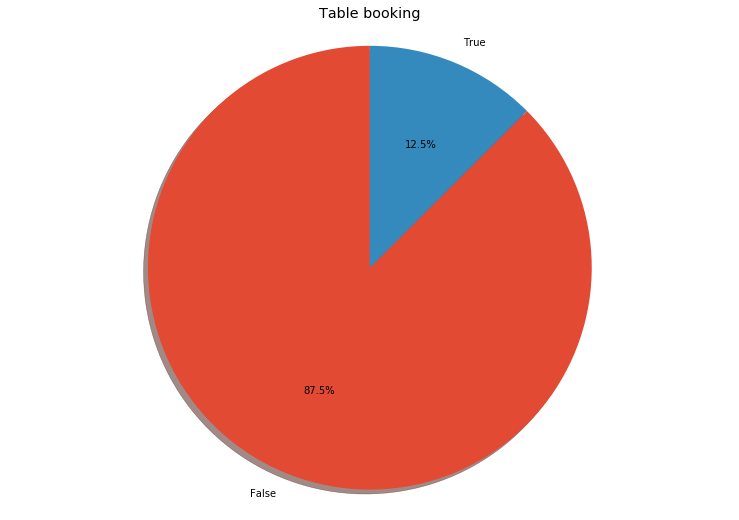

In [28]:
x=dataset['book_table'].value_counts()
sizes = x
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=x.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.title("Table booking")
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('code/output/Fig_5-Book_table.png', dpi=300) 
plt.show()
    

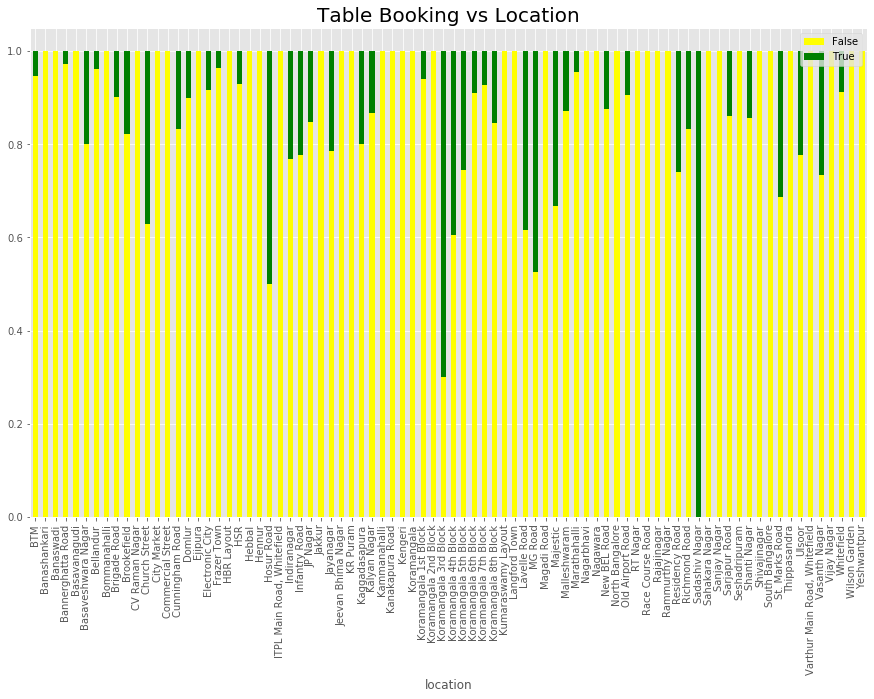

In [29]:
#Table online_order vs Rate
plt.rcParams['figure.figsize'] = (15, 9)
Y = pd.crosstab(dataset['location'], dataset['book_table'])
Y.div(Y.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True,color=['yellow','green'])
plt.title('Table Booking vs Location', fontweight = 30, fontsize = 20)
plt.legend(loc="upper right")
plt.show()

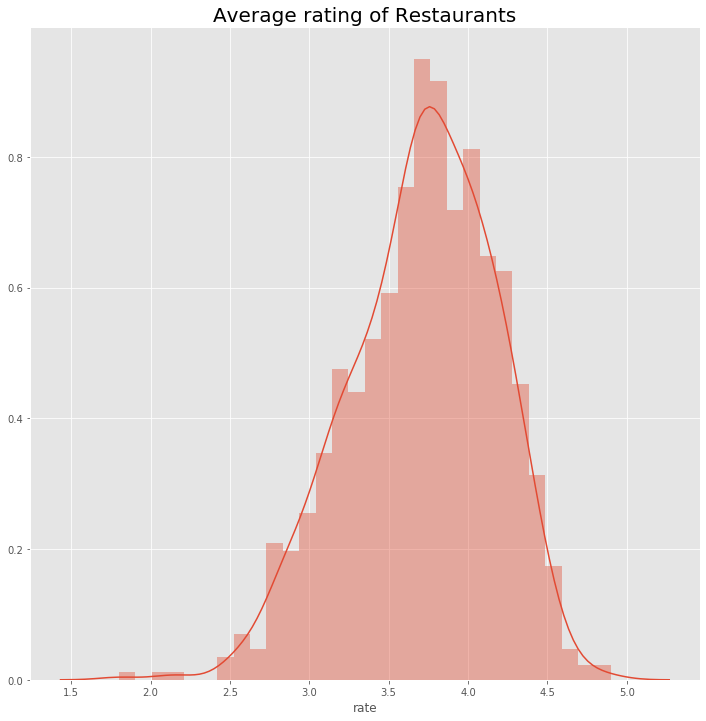

In [30]:
plt.figure(figsize=(12,12))
plt.title('Average rating of Restaurants', fontweight = 30, fontsize = 20)
rating=dataset['rate'].dropna().apply(lambda x : float(x.split('/')[0]) if (len(x)>3)  else np.nan ).dropna()
sns.distplot(rating,bins=30)
plt.savefig('code/output/Fig_5-average_rating.png', dpi=300) 

More than 60 percent of restaurants has rating between 3 and 4.
Restaurants having rating more than 4.5 are very rare and very few restaurants have rating below 2.5

# generating seconday variable
cost_dist=dataset[['rate','average_cost','online_order']].dropna()
cost_dist['rate']=cost_dist['rate'].apply(lambda x: float(x.split('/')[0]) if len(x)>3 else 0)
cost_dist['average_cost']=cost_dist['average_cost'].apply(lambda x: int(x.replace(',','')))

plt.figure(figsize=(12,12))
plt.title('Average cost of dining vs online order', fontweight = 30, fontsize = 20)
sns.scatterplot(x="rate",y='average_cost',hue='online_order',data=cost_dist)
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


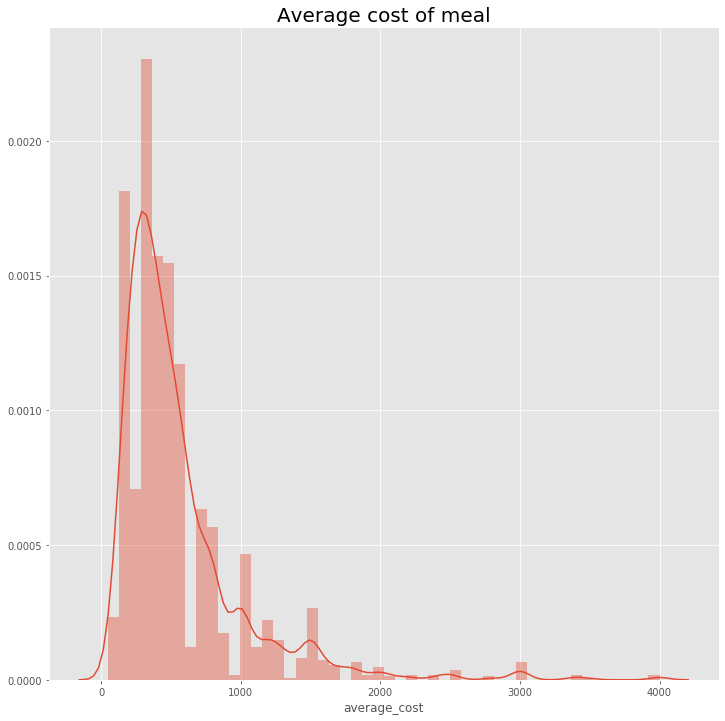

In [31]:
plt.figure(figsize=(12,12))
plt.title('Average cost of meal', fontweight = 30, fontsize = 20)
sns.distplot(dataset['average_cost'], bins=50)
plt.savefig('code/output/Fig_5-average_cost_of_meal.png', dpi=300) 
plt.show()

We can see that the distribution if left skewed.
This means almost 80 percent of restaurants serve food for budget less than 1000.

Text(0.5, 0, 'count')

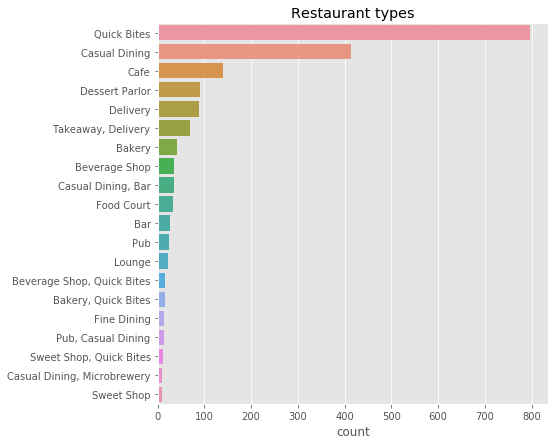

In [32]:
plt.figure(figsize=(7,7))
rest=dataset['rest_type'].value_counts()[:20]
sns.barplot(rest,rest.index)
plt.title("Restaurant types")
plt.xlabel("count")

No doubt about this as Banglore is known as the tech capital of India,people having busy and modern life will prefer Quick Bites.
We can observe tha Quick Bites type restaurants dominates.

I have implemented a simple filtering mechanism to find best budget restaurants in any locations in Bangalore.
You can pass location and restaurant type as parameteres,function will return name of restaurants.

cost_dist=dataset[['rate','average_cost','location','name','rest_type']].dropna()
cost_dist['rate']=cost_dist['rate'].apply(lambda x: float(x.split('/')[0]) if len(x)>3 else 0)
cost_dist['average_cost']=cost_dist['average_cost'].apply(lambda x: int(x.replace(',','')))

In [34]:
def return_budget(location,rest):
    budget=cost_dist[(cost_dist['average_cost']<=400) & (cost_dist['location']==location) & 
                     (cost_dist['rate']>4) & (cost_dist['rest_type']==rest)]
    return(budget['name'].unique())

return_budget('BTM',"Quick Bites")

array(["Muthashy'S"], dtype=object)

Foody Areas

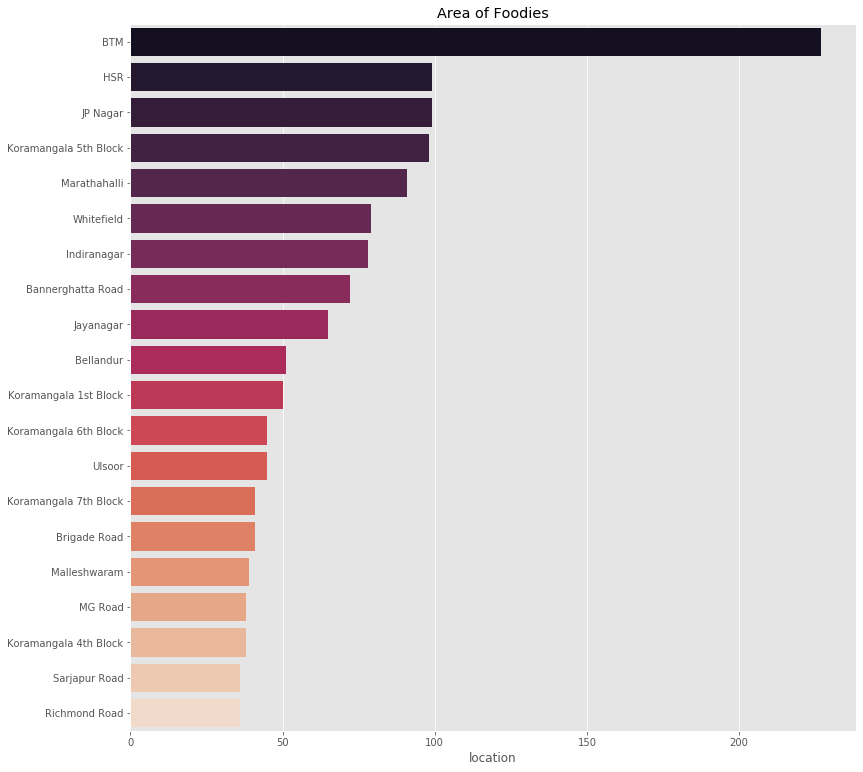

In [35]:
fig = plt.gcf()
fig.set_size_inches(13,13)
plt.title('Area of Foodies')
Rest_locations=dataset['location'].value_counts()[:20]
sns.barplot(Rest_locations,Rest_locations.index,palette="rocket")

We can see that BTM,JP Nagar , HSR and Koranmangala 5th block has the most number of restaurants.
BTM dominates the section by having more than 200 restaurants.

Most comman cuisines in each location

In [37]:
df_1=dataset.groupby(['location','cuisines']).agg('count')
data=df_1.sort_values(['SNO'],ascending=False).groupby(['location'],as_index=False).apply(lambda x : x.sort_values(by="SNO",ascending=False).head(3))['SNO'].reset_index().rename(columns={'SNO':'count'})
data.head(10)

,level_0,location,cuisines,count
0,0,BTM,North Indian,17
1,0,BTM,"North Indian, Chinese",13
2,0,BTM,Fast Food,7
3,1,Banashankari,North Indian,3
4,1,Banashankari,South Indian,3
5,1,Banashankari,"Bakery, Desserts",2
6,2,Banaswadi,"North Indian, Chinese",3
7,2,Banaswadi,"Ice Cream, Desserts",2
8,2,Banaswadi,"Bakery, Desserts, Fast Food",2
9,3,Bannerghatta Road,"North Indian, Chinese",7


Text(0.5, 1.0, 'Type of Restaurants delivering online or Not')

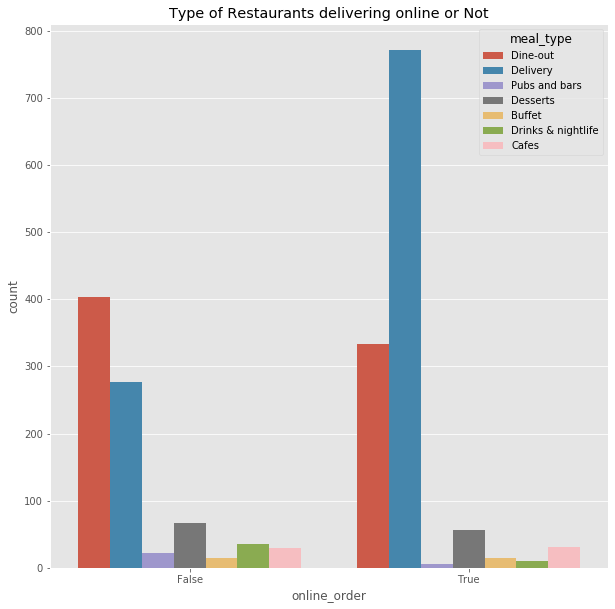

In [38]:
sns.countplot(x=dataset['online_order'], hue = dataset['meal_type'])
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.title('Type of Restaurants delivering online or Not')

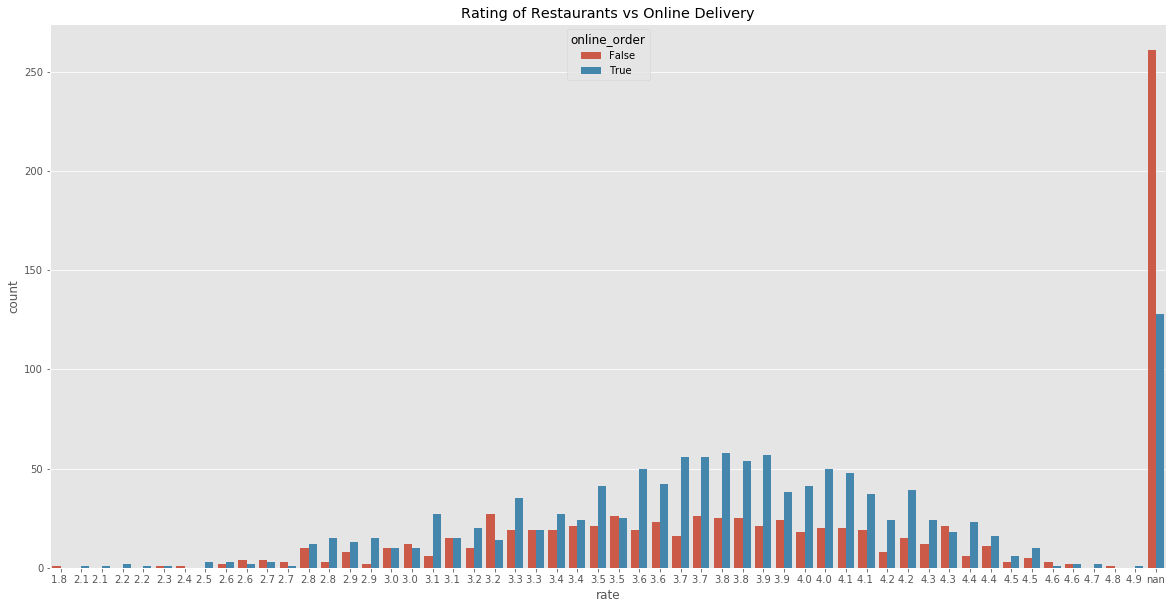

In [39]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='rate',hue='online_order',data=dataset)
plt.title('Rating of Restaurants vs Online Delivery')
plt.show()

Count of Most liked dishes of Bangalore


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  


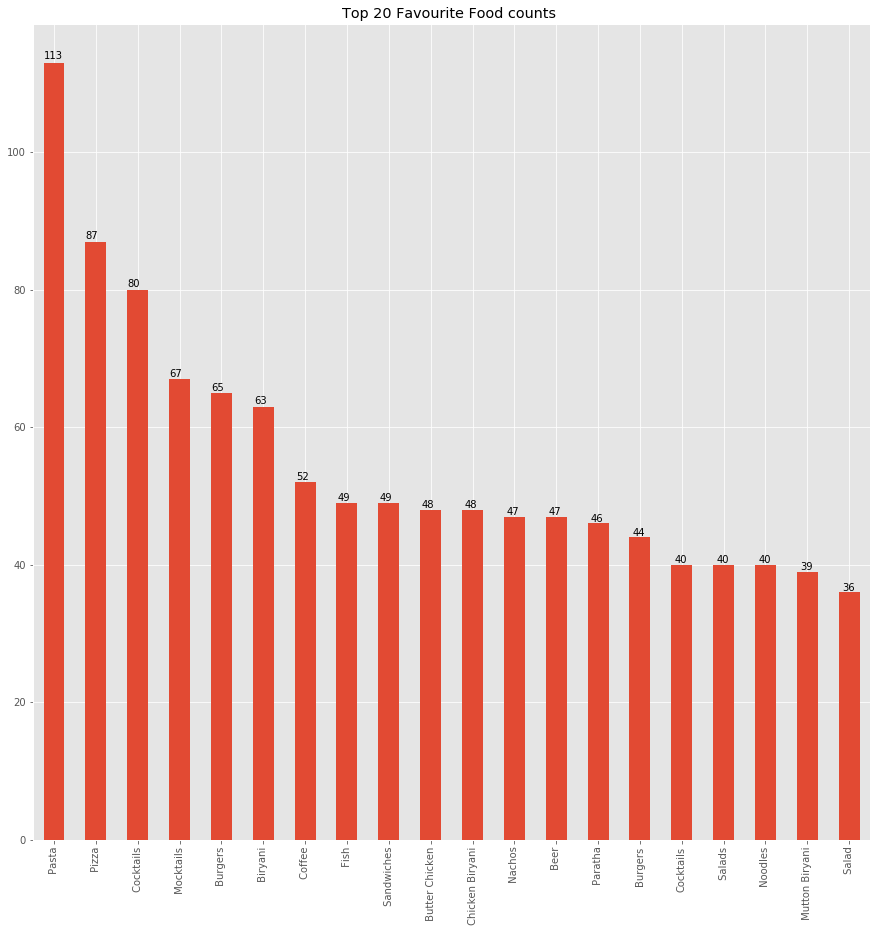

In [41]:
import re
dataset=dataset[dataset['dish_liked'].notnull()]
dataset.index=range(dataset.shape[0])
likes=[]
for i in range(dataset.shape[0]):
    splited_array=re.split(',',dataset['dish_liked'][i])
    for item in splited_array:
        likes.append(item)

print("Count of Most liked dishes of Bangalore")
favourite_food = pd.Series(likes).value_counts()
favourite_food.head(20)

ax = favourite_food.nlargest(n=20, keep='first').plot('bar',figsize=(15,15),title = 'Top 20 Favourite Food counts ')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.savefig('ss.png', dpi=300)
    

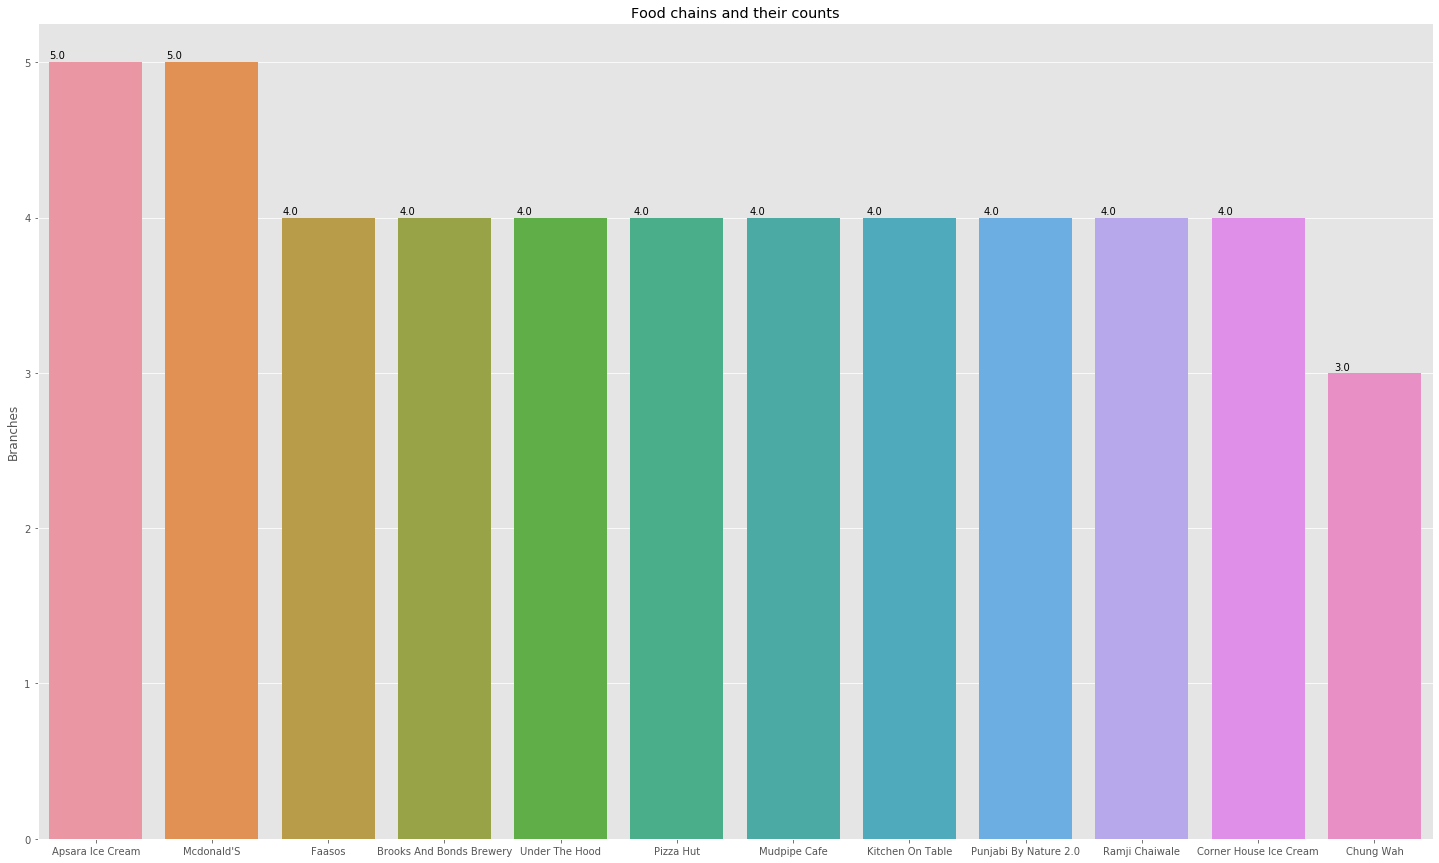

In [42]:
branches = dataset.groupby(['name']).size().to_frame('count').reset_index().sort_values(['count'],ascending=False)
ax = sns.barplot(x='name', y='count', data=branches[:12])
plt.xlabel('')
plt.ylabel('Branches')
plt.title('Food chains and their counts')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    
fig = plt.gcf()
fig.set_size_inches(25,15)

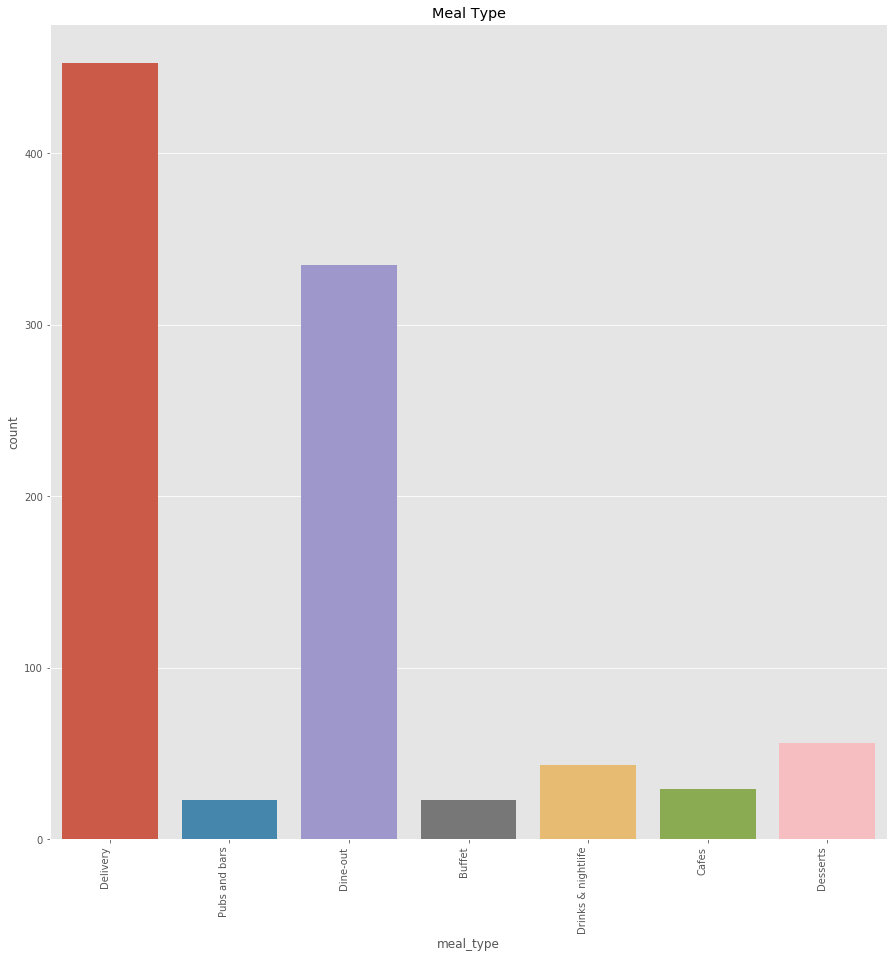

In [52]:
#Meal Type
sns.countplot(dataset['meal_type']).set_xticklabels(sns.countplot(dataset['meal_type']).get_xticklabels(), rotation=90, ha="right")
fig = plt.gcf()
fig.set_size_inches(15,15)
plt.title('Meal Type')

plt.savefig('ss.png', dpi=300)


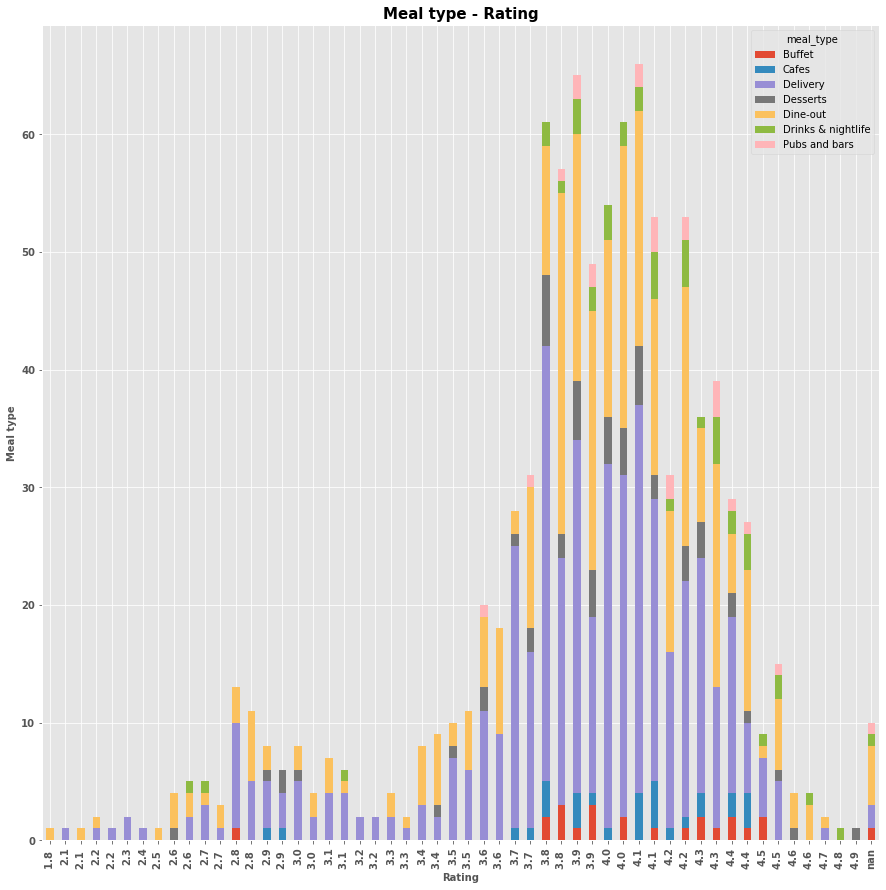

In [53]:
#Gaussian Meal type and Rating
loc_plt=pd.crosstab(dataset['rate'],dataset['meal_type'])
loc_plt.plot(kind='bar',stacked=True);
fig = plt.gcf()
fig.set_size_inches(15,15)
plt.title('Meal type - Rating',fontsize=15,fontweight='bold')
plt.ylabel('Meal type',fontsize=10,fontweight='bold')
plt.xlabel('Rating',fontsize=10,fontweight='bold')
plt.xticks(fontsize=10,fontweight='bold')
plt.yticks(fontsize=10,fontweight='bold');
#plt.legend().remove();

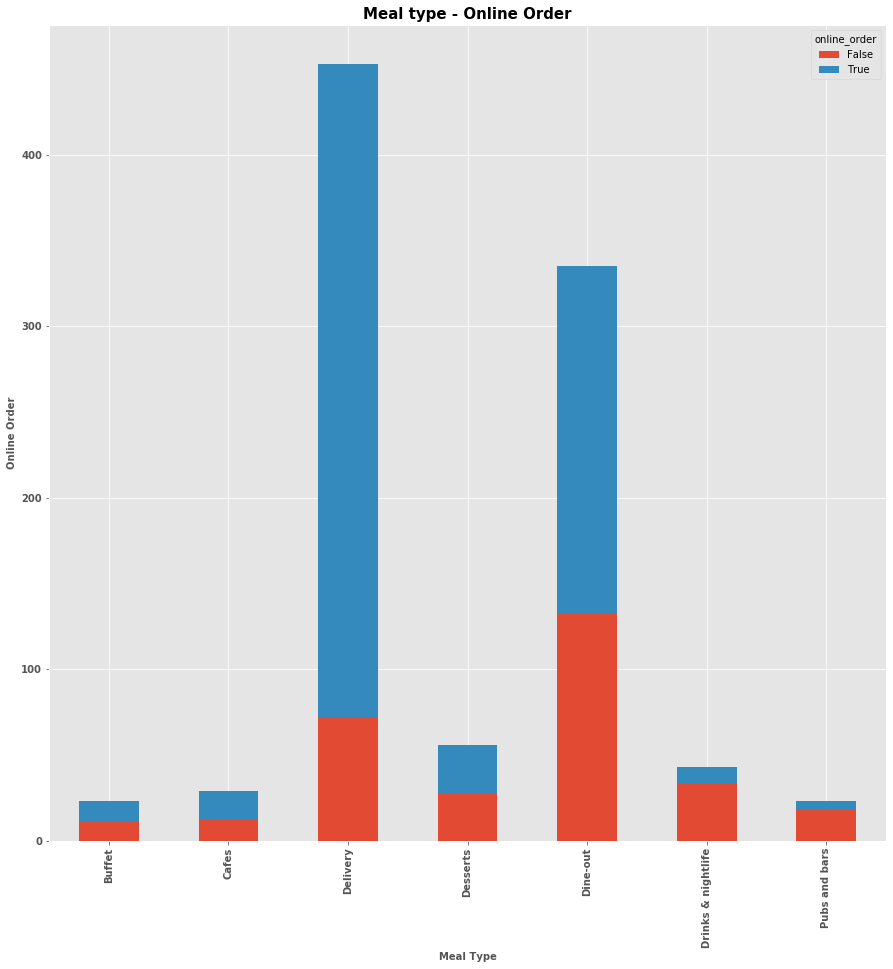

In [54]:
#Gaussian Meal type and Rating
loc_plt=pd.crosstab(dataset['meal_type'],dataset['online_order'])
loc_plt.plot(kind='bar',stacked=True);
fig = plt.gcf()
fig.set_size_inches(15,15)
plt.title('Meal type - Online Order',fontsize=15,fontweight='bold')
plt.ylabel('Online Order',fontsize=10,fontweight='bold')
plt.xlabel('Meal Type',fontsize=10,fontweight='bold')
plt.xticks(fontsize=10,fontweight='bold')
plt.yticks(fontsize=10,fontweight='bold');
#plt.legend().remove();

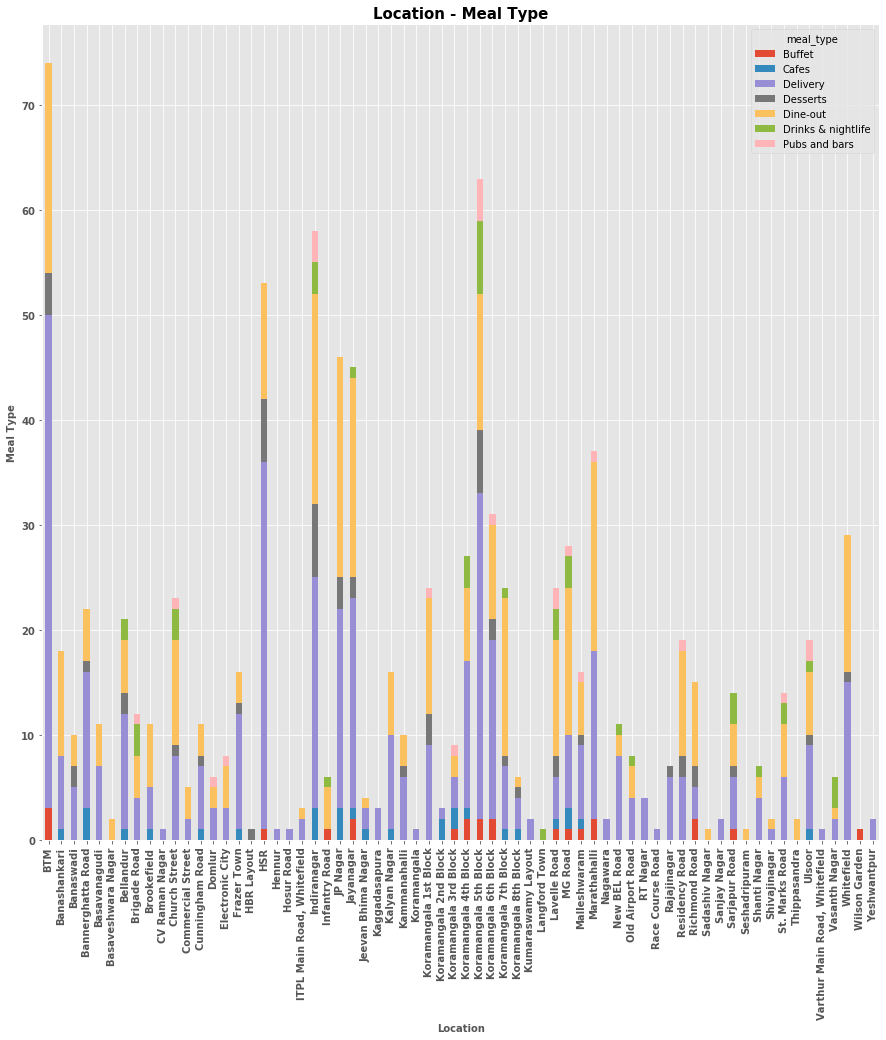

In [55]:
#Gaussian Meal type and Rating
loc_plt=pd.crosstab(dataset['location'],dataset['meal_type'])
loc_plt.plot(kind='bar',stacked=True);
fig = plt.gcf()
fig.set_size_inches(15,15)
plt.title('Location - Meal Type',fontsize=15,fontweight='bold')
plt.ylabel('Meal Type',fontsize=10,fontweight='bold')
plt.xlabel('Location',fontsize=10,fontweight='bold')
plt.xticks(fontsize=10,fontweight='bold')
plt.yticks(fontsize=10,fontweight='bold');
#plt.legend().remove();

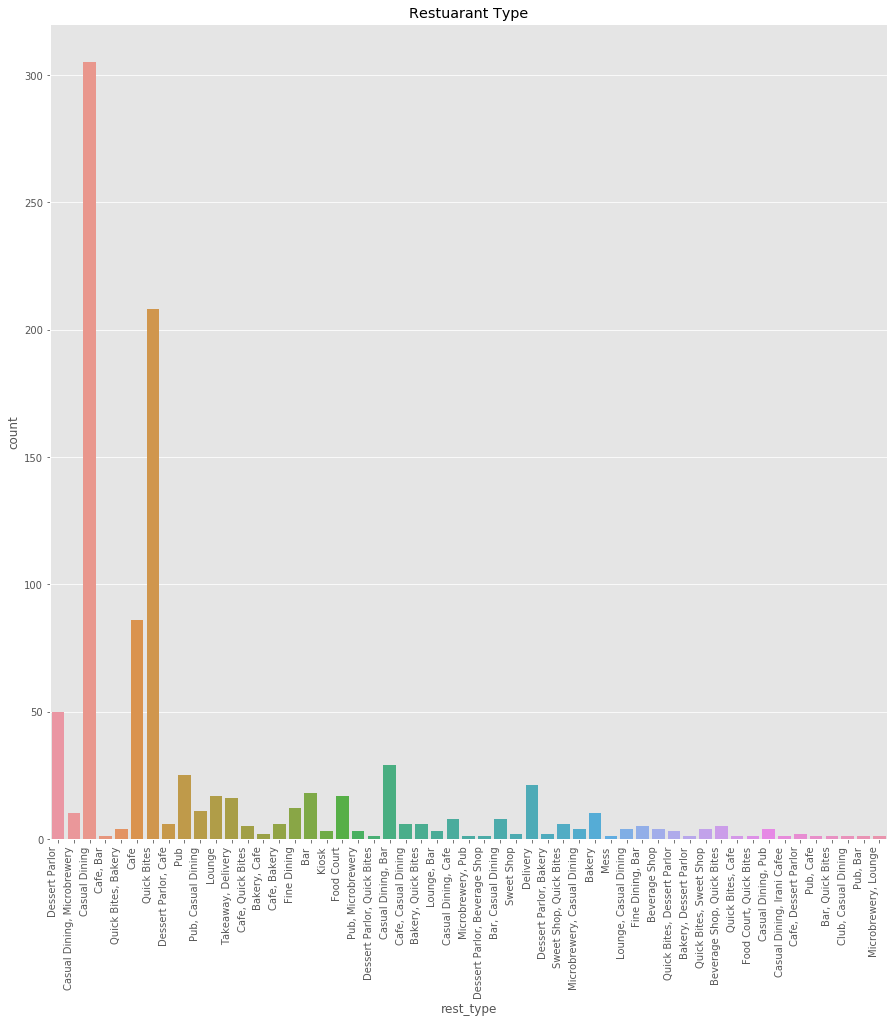

In [47]:
#Restaurant Type
sns.countplot(dataset['rest_type'])
sns.countplot(dataset['rest_type']).set_xticklabels(sns.countplot(dataset['rest_type']).get_xticklabels(), rotation=90, ha="right")
fig = plt.gcf()
fig.set_size_inches(15,15)
plt.title('Restuarant Type')
plt.savefig('line_plot_hq.png', dpi=300)  

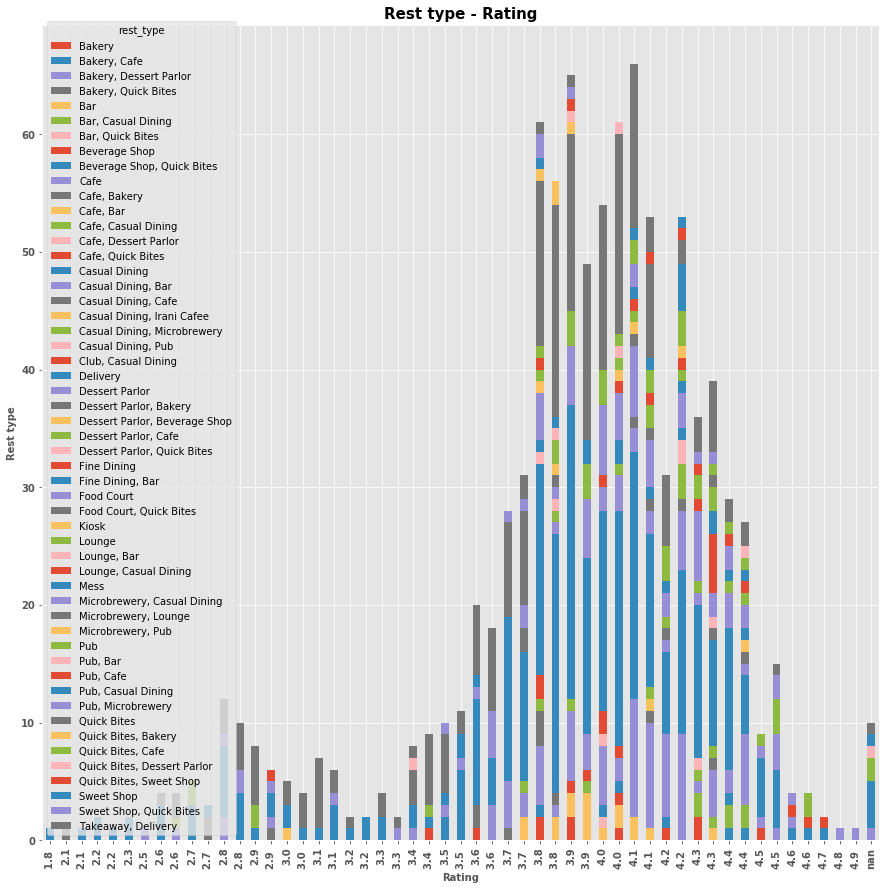

In [56]:
#Gaussian Rest type and Rating
loc_plt=pd.crosstab(dataset['rate'],dataset['rest_type'])
loc_plt.plot(kind='bar',stacked=True);
fig = plt.gcf()
fig.set_size_inches(15,15)
plt.title('Rest type - Rating',fontsize=15,fontweight='bold')
plt.ylabel('Rest type',fontsize=10,fontweight='bold')
plt.xlabel('Rating',fontsize=10,fontweight='bold')
plt.xticks(fontsize=10,fontweight='bold')
plt.yticks(fontsize=10,fontweight='bold');
plt.legend().remove();

Text(0.5, 1.0, 'Location')

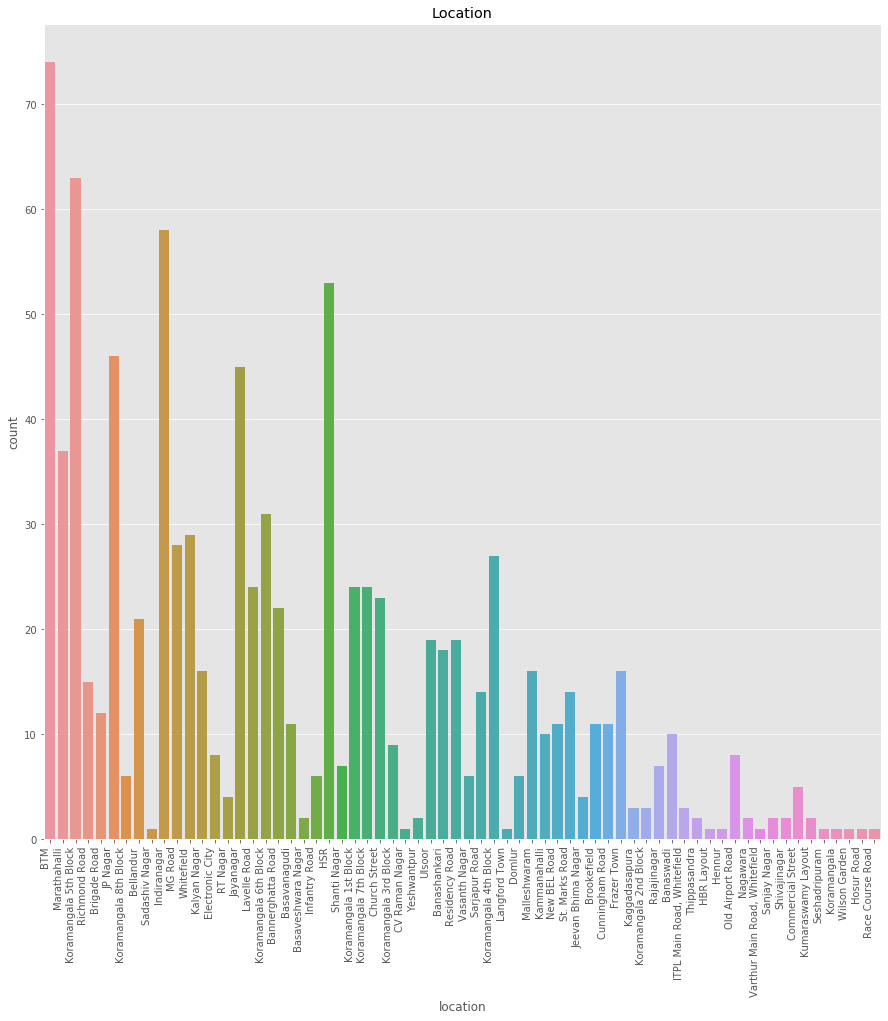

In [49]:
#Restaurant Type
sns.countplot(dataset['location']).set_xticklabels(sns.countplot(dataset['location']).get_xticklabels(), rotation=90, ha="right",
                                            )
fig = plt.gcf()
fig.set_size_inches(15,15)
plt.title('Location')

Text(0.5, 1.0, 'Online Orders')

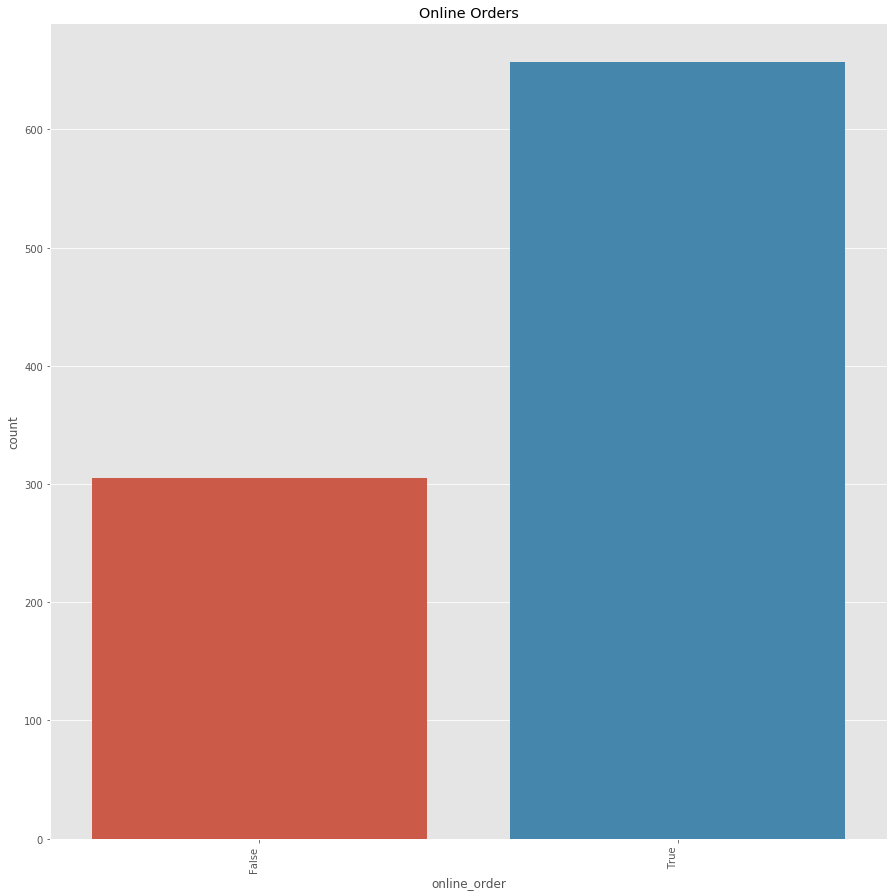

In [50]:
#Restaurant Type
sns.countplot(dataset['online_order']).set_xticklabels(sns.countplot(dataset['online_order']).get_xticklabels(), rotation=90, ha="right",
                                            )
fig = plt.gcf()
fig.set_size_inches(15,15)
plt.title('Online Orders')


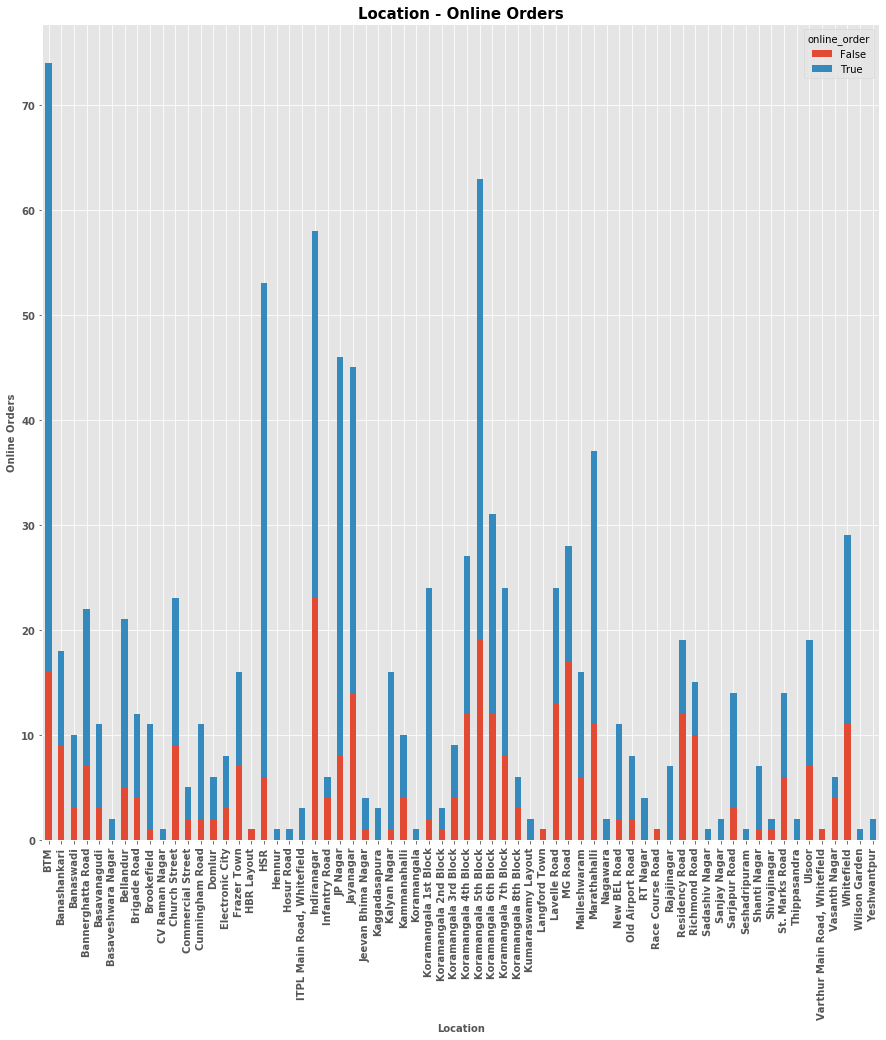

In [57]:
#Gaussian Rest type and Ratinga
#plt.legend().remove();

In [ ]:
dataset['average_cost'] = dataset['average_cost'].astype('str')
dataset['average_cost'] = dataset['average_cost'].apply(lambda x: x.replace(',',''))
dataset['average_cost'] = dataset['average_cost'].astype("float")
sns.boxplot(dataset['average_cost'])
plt.title('Approx 70% restaurants offer meal for less than 1000',fontsize=15,fontweight='bold')